In [24]:
import numpy as np
import cvxpy as cp
import pandas as pd
from scipy.io import netcdf
import math
import matplotlib.pyplot as plt
import _GraphUtils as gu
from scipy.integrate import solve_ivp

def Cp_calc(lmbd_in=0):
    path = r'Datasets/Cp_X_lambda.csv'
    df = pd.read_csv(path)
    dist = np.abs(df['lambda'].values - lmbd_in)
    return (df['cp'].values[np.argmin(dist)])

params = {
    "Bdt": 755.49,
    "Kdt": 2.7*1e9,
    "Jg": 55*1e6,
    "Jr": 55*1e6,
    "rho": 1.225,
    "Ar": math.pi * (57.5**2),
    "Rr":  57.5,
    "Cp_Max": 0.486,
    "Lambda_opt": 7.6,
    "Dmax": 1000,
    "Vmax": 5,
    "Vmin": 0.2
}

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100) 

path = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*5

In [38]:


class DriveTrain:
    def __init__(self, **params):

        self.rho = params['rho'] 
        self.A = params['Ar'] 
        self.R = params['Rr'] 
        self.Bdt = params['Bdt']
        self.Kdt = params['Kdt']
        self.Jr = params['Jr']
        self.Jg = params['Jg']
        self.lmbd_opt = params['Lambda_opt']
        self.Cp_star = params['Cp_Max']
        self.X = np.array([0,0,0])
        self.dX = np.array([0,0,0])
        self.U = np.array([0,0])
        self.tR_ = np.array([0])
        self.wR_ = np.array([0])
        self.ED = np.array([0])
        self.EG = np.array([0])
        self.K_mppt = np.array([[0]])
        self.X_ = np.array([[0,0,0]])
        self.dX_ = np.array([[0,0,0]])
        self.k = 1
        self.cp_=[]
        self.lmbd_=[]

    def set_state(self, X):
        """
        Define the current state of the plant. 
        
        x : array-like
            Current state [omega_r, omega_g, theta]
        """
        self.X = X.flatten()

    def dynamics(self, t, X, U):


        Bdt = self.Bdt 
        Kdt = self.Kdt 
        Jr = self.Jr 
        Jg = self.Jg 
        
        A=np.array([[-Bdt/Jr,  0/Jr, -0/Jr],
                    [ 0/Jg, -0/Jg,  0/Jg],
                    [    0,    0,     0]])
        
        B = np.array([[1/Jr,      0],
                      [    0, 0/Jg],
                      [    0,     0]])
        
        dX = (A@X.reshape(-1,1))+(B@U.reshape(-1,1))
        self.dX = dX.flatten()
        return dX.flatten()
    
    def compute_input(self, v, X, uk=0):
        
        wR = X[0]
        wg = 0
        rho = self.rho
        A = self.A
        R = self.R
       
        lmbd = wR*R/v
        Cp = Cp_calc(lmbd)
        if Cp < 0:
            Cp=self.cp_[-1]
            lmbd=self.lmbd_[-1]
        self.cp_.append(Cp)
        self.lmbd_.append(lmbd)
     
        tR = 0.5*rho*A*Cp*(v**3)/wR
        print('v:',v,'lmbd:',lmbd,'Cp:',Cp, 'tR:', tR)
        du = np.array([tR,0])
        self.U = du
        self.tR_ = np.append(self.tR_,tR)
        self.wR_ = np.append(self.wR_,wR)
        
        return du
    
    def iterate(self, u, dt):
        """
        Propagate the system forward in time by 'dt' using 
        numerical integration.
        
        Parameters:
        u : array-like
            Input vector [u1, u2]
        dt : float
            Time step
        """
        #DOP853
        sol = solve_ivp(self.dynamics, [0, dt], self.X, 
            args=(u.flatten(),), method="DOP853", t_eval=[dt])
        self.X = sol.y[:, -1]
        return self.X
    


In [39]:
dTrain = DriveTrain(**params)
X=np.array([0.001,0,0])
dTrain.set_state(X)
e = 2000
for i,v_ in enumerate(v[:e]):
    U = dTrain.compute_input(v_,X,uk=0)
    X = dTrain.iterate(U,1)

v: 16.595544582808966 lmbd: 0.0034647853653180655 Cp: 0.0021 tR: 61064031.710251
v: 16.440798338280292 lmbd: 3.886473695259417 Cp: 0.2006 tR: 5103645.499429
v: 16.384298123508373 lmbd: 4.225475195713592 Cp: 0.2525 tR: 5868147.328284394
v: 16.990639334645415 lmbd: 4.435697328953245 Cp: 0.2845499999999999 tR: 6774474.738077631
v: 16.846765268145692 lmbd: 4.893916057023824 Cp: 0.353 tR: 7488774.248019124
v: 16.701150409477783 lmbd: 5.4052948241961545 Cp: 0.4083 tR: 7707477.531256441
v: 17.320243935926538 lmbd: 5.67723897465452 Cp: 0.42905 tR: 8293507.449153051
v: 17.218197495673003 lmbd: 6.214369348246652 Cp: 0.4531 tR: 7907366.529510798
v: 16.575685506186463 lmbd: 6.95389065179472 Cp: 0.47685 tR: 6892177.05957057
v: 17.53935004497031 lmbd: 6.982546629435639 Cp: 0.4835 tR: 7792362.093161437
v: 17.255751939570757 lmbd: 7.569310926932969 Cp: 0.4867 tR: 7003776.499078432
v: 16.96866081928683 lmbd: 8.128775672852802 Cp: 0.4848 tR: 6281915.78397313
v: 16.714682916525817 lmbd: 8.645091002664191

0.0


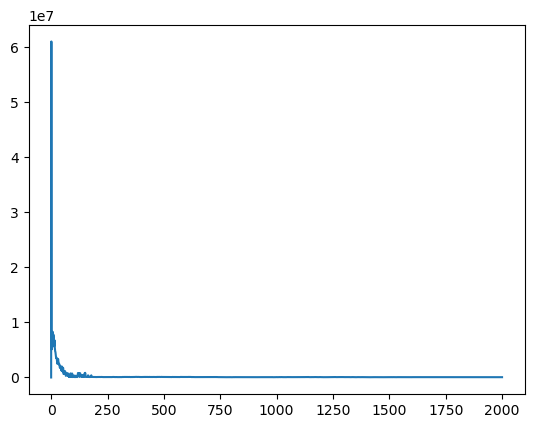

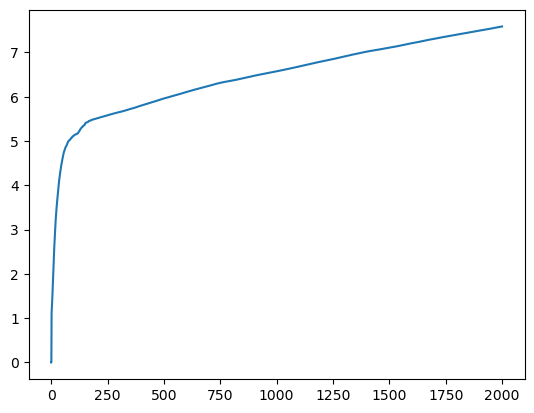

In [37]:
print(np.min(dTrain.tR_))
plt.plot(dTrain.tR_)
plt.show()
plt.plot(dTrain.wR_)
plt.show()

In [80]:
tempo_simulacao_s = len(v) # Duração maior para observar a aceleração
pontos_simulacao = len(v) 
tempo_vetor = np.linspace(1, tempo_simulacao_s, pontos_simulacao)
tempo_vetor

array([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,
         10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,
         19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,